In [1]:
from hat.mapping.evaluation import calculate_mae, calculate_rmse, count_within_abs_error_range, count_perfect_mapping, plot_distance_histogram, plot_area_error_histogram
import pandas as pd
import xarray as xr


df = pd.read_csv("~/freelance/02_ort_ecmwf/dev/hat/hat/mapping/output/stations.csv")
tolerance_degrees =1/60/2
dist_interval = 50
area_diff_interval = 10
y_max = 100
error_margin = 20


### Evaluation between manual mapping and station metadata

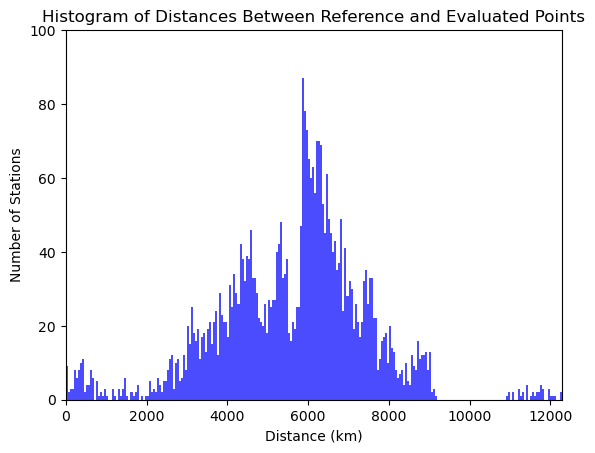

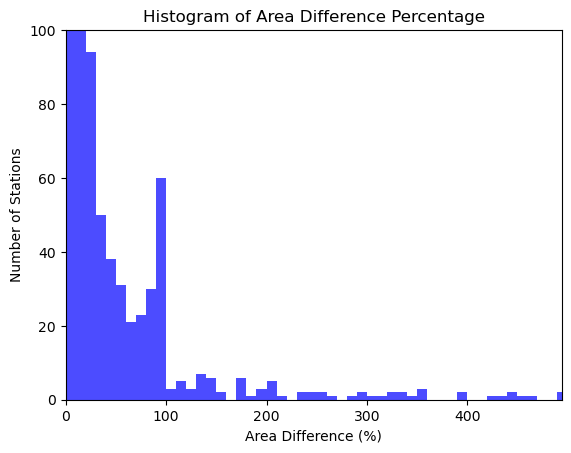

Count of perfect mapping rows with distance within 0.008333333333333333 decimal degrees: 0 / 3683
Count of rows with absolute error % between manual_area and station_area in the range of (0%, 20%): 3180 / 3697
Mean Abs. Error (MAE) % between manual_area and station_area: 1375.19%


In [5]:
# Evaluation between manual mapping and station metadata
fig1 = plot_distance_histogram(df, 'manual_lat', 'manual_lon', 'station_lat', 'station_lon', dist_interval, y_max)
fig2 = plot_area_error_histogram(df, 'manual_area', 'station_area', area_diff_interval, y_max, max_area_error=500)
perfect_mapping_count = count_perfect_mapping(df, 'manual_lat', 'manual_lon', 'station_lat', 'station_lon', tolerance_degrees)
acceptable_count = count_within_abs_error_range(df, 'manual_area', 'station_area', lower_limit=0 , upper_limit=error_margin)
mae = calculate_mae(df, 'manual_area', 'station_area')

### Evaluation between manual mapping and nearest station

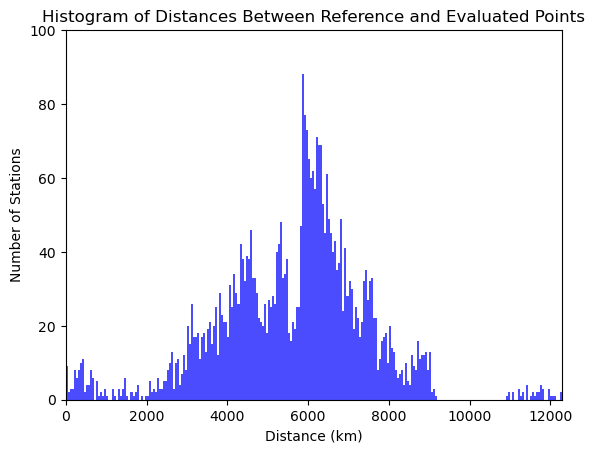

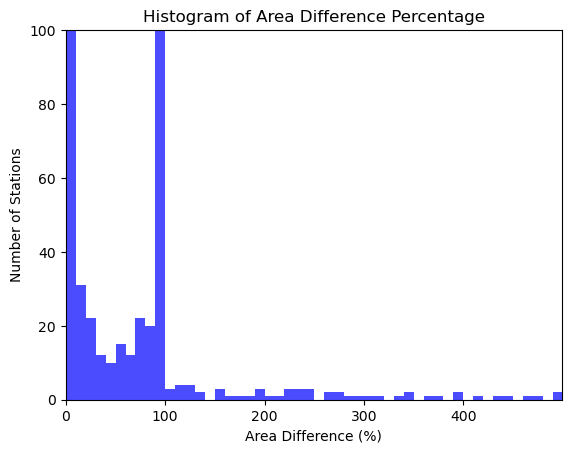

Count of perfect mapping rows with distance within 5 decimal degrees: 84 / 3683
Count of rows with absolute error % between manual_area and near_grid_area in the range of (0%, 20%): 2884 / 3697
Mean Abs. Error (MAE) % between manual_area and near_grid_area: 149.33%


In [6]:
# Evaluation between manual mapping and nearest grid
fig1 = plot_distance_histogram(df, 'manual_lat', 'manual_lon', 'near_grid_lat', 'near_grid_lon', dist_interval, y_max)
fig2 = plot_area_error_histogram(df, 'manual_area', 'near_grid_area', area_diff_interval, y_max, max_area_error=500)
perfect_mapping_count = count_perfect_mapping(df, 'manual_lat', 'manual_lon', 'near_grid_lat', 'near_grid_lon', tolerance_degrees = 5)
acceptable_count = count_within_abs_error_range(df, 'manual_area', 'near_grid_area', lower_limit=0 , upper_limit=error_margin)
mae = calculate_mae(df, 'manual_area', 'near_grid_area')

### Evaluation between manual mapping and best grid found

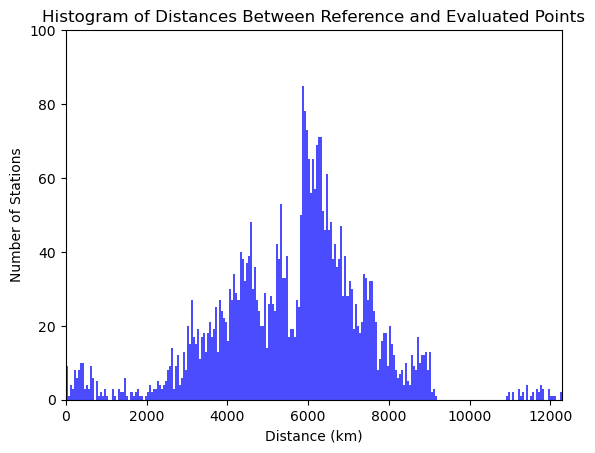

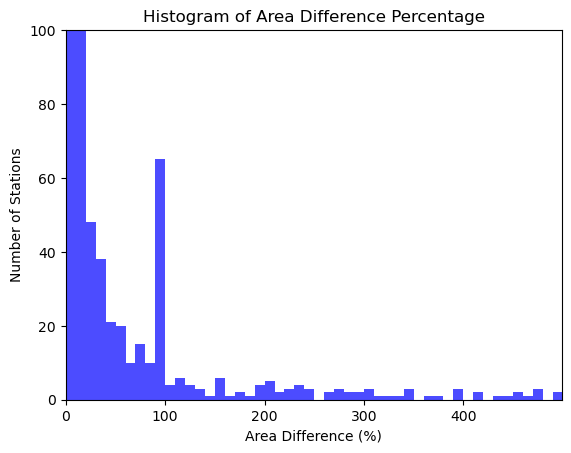

Count of perfect mapping rows with distance within 5 decimal degrees: 84 / 3683
Count of rows with absolute error % between manual_area and new_grid_area in the range of (0%, 20%): 3296 / 3697
Mean Abs. Error (MAE) % between manual_area and new_grid_area: 259.52%


In [7]:
# Evaluation between manual mapping and / new grid
fig = plot_distance_histogram(df, 'manual_lat', 'manual_lon', 'new_grid_lat', 'new_grid_lon', dist_interval, y_max)
fig2 = plot_area_error_histogram(df, 'manual_area', 'new_grid_area', area_diff_interval, y_max, max_area_error=500)
perfect_mapping_count = count_perfect_mapping(df, 'manual_lat', 'manual_lon', 'new_grid_lat', 'new_grid_lon', tolerance_degrees = 5)
acceptable_count = count_within_abs_error_range(df, 'manual_area', 'new_grid_area', lower_limit=0 , upper_limit=error_margin)
mae = calculate_mae(df, 'manual_area', 'new_grid_area')